## Crypto Prediction with LSTM: BitCoin (BTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow_addons.metrics import RSquare
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.metrics import R2Score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

In [3]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-14T00:00:00.0000000Z', 'time_period_end': '2023-09-15T00:00:00.0000000Z', 'time_open': '2023-09-14T00:00:15.5360000Z', 'time_close': '2023-09-14T16:02:57.6340000Z', 'price_open': 26229, 'price_high': 26797, 'price_low': 26143, 'price_close': 26716, 'volume_traded': 1642.16774424, 'trades_count': 10445}, {'time_period_start': '2023-09-13T00:00:00.0000000Z', 'time_period_end': '2023-09-14T00:00:00.0000000Z', 'time_open': '2023-09-13T00:00:26.7790000Z', 'time_close': '2023-09-13T23:59:42.8740000Z', 'price_open': 25842, 'price_high': 26395, 'price_low': 25762, 'price_close': 26226, 'volume_traded': 1562.75522538, 'trades_count': 12274}, {'time_period_start': '2023-09-12T00:00:00.0000000Z', 'time_period_end': '2023-09-13T00:00:00.0000000Z', 'time_open': '2023-09-12T00:00:20.4450000Z', 'time_close': '2023-09-12T23:59:52.9300000Z', 'price_open': 25157, 'price_high': 26529, 'price_low': 25129, 'price_close': 25844, 'volume_traded': 3093.36598557, 'trades_count':

In [4]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:00:15.5360000Z,2023-09-14T16:02:57.6340000Z,26229.0,26797.0,26143.0,26716.0,1642.167744,10445
1,2023-09-13T00:00:00.0000000Z,2023-09-14T00:00:00.0000000Z,2023-09-13T00:00:26.7790000Z,2023-09-13T23:59:42.8740000Z,25842.0,26395.0,25762.0,26226.0,1562.755225,12274
2,2023-09-12T00:00:00.0000000Z,2023-09-13T00:00:00.0000000Z,2023-09-12T00:00:20.4450000Z,2023-09-12T23:59:52.9300000Z,25157.0,26529.0,25129.0,25844.0,3093.365986,18119
3,2023-09-11T00:00:00.0000000Z,2023-09-12T00:00:00.0000000Z,2023-09-11T00:01:04.0430000Z,2023-09-11T23:59:54.2240000Z,25839.0,25881.0,24920.0,25155.0,2008.594076,15049
4,2023-09-10T00:00:00.0000000Z,2023-09-11T00:00:00.0000000Z,2023-09-10T00:00:25.1010000Z,2023-09-10T23:58:35.8900000Z,25899.0,26018.0,25588.0,25836.0,879.786122,7268


In [5]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


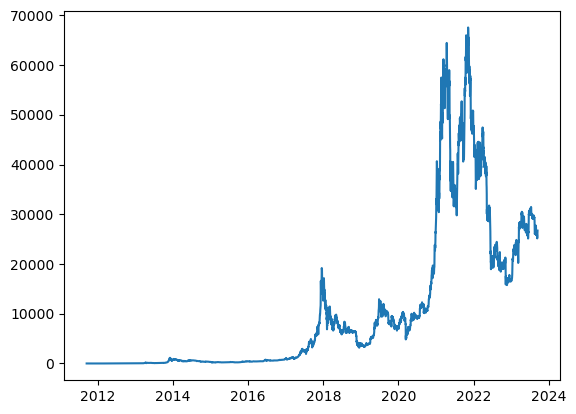

In [10]:
#plot historical amzn price
plt.plot(data)

In [11]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [12]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np)



# check shapes
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4225, 7), (4225,), (4225,))

In [13]:
# non_positive_indices = np.where(shifted_df_as_np <= 0)
# print(non_positive_indices)


In [14]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3380, 7), (3380,), (422, 7), (422,), (423, 7), (423,))

In [15]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-14 12:03:18.473948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
106/106 [==============================] - 3s 11ms/step - loss: 14.7792 - mean_absolute_error: 2.6662 - val_loss: 0.4596 - val_mean_absolute_error: 0.6557
Epoch 2/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0183 - mean_absolute_error: 0.0829 - val_loss: 0.0470 - val_mean_absolute_error: 0.1951
Epoch 3/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0561 - val_loss: 0.0179 - val_mean_absolute_error: 0.1170
Epoch 4/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0511 - val_loss: 0.0048 - val_mean_absolute_error: 0.0546
Epoch 5/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0492 - val_loss: 0.0057 - val_mean_absolute_error: 0.0608
Epoch 6/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0050 - mean_absolute_error: 0.0487 - val_loss: 0.0038 - val_mean_absolute_error: 0.0486
Epoch 7/

106/106 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0413 - val_loss: 0.0020 - val_mean_absolute_error: 0.0354
Epoch 51/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0420 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 52/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0390 - val_loss: 0.0058 - val_mean_absolute_error: 0.0650
Epoch 53/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0399 - val_loss: 0.0020 - val_mean_absolute_error: 0.0336
Epoch 54/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0038 - mean_absolute_error: 0.0432 - val_loss: 0.0062 - val_mean_absolute_error: 0.0704
Epoch 55/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0424 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353
Epoch 56/100
106/

106/106 [==============================] - 1s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0396 - val_loss: 0.0016 - val_mean_absolute_error: 0.0295
Epoch 100/100
106/106 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0396 - val_loss: 0.0031 - val_mean_absolute_error: 0.0474


106/106 [==============================] - 1s 3ms/step


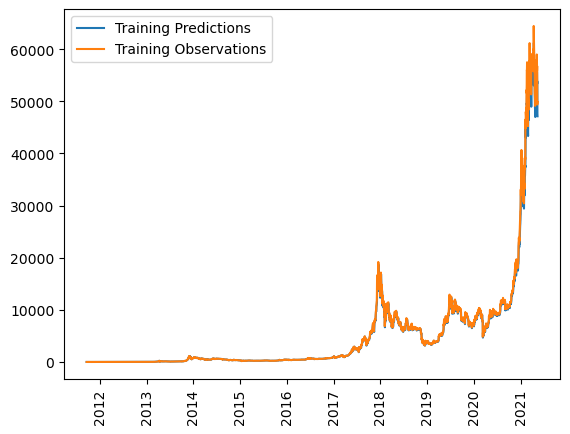

In [16]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [17]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.003147408366203308
Val MAE: 0.04737856984138489


14/14 [==============================] - 0s 3ms/step


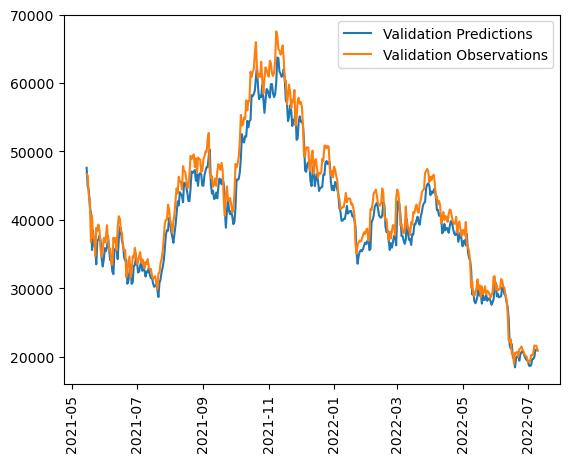

In [18]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [19]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0017415833426639438
Test MAE: 0.03543039411306381


14/14 [==============================] - 0s 3ms/step


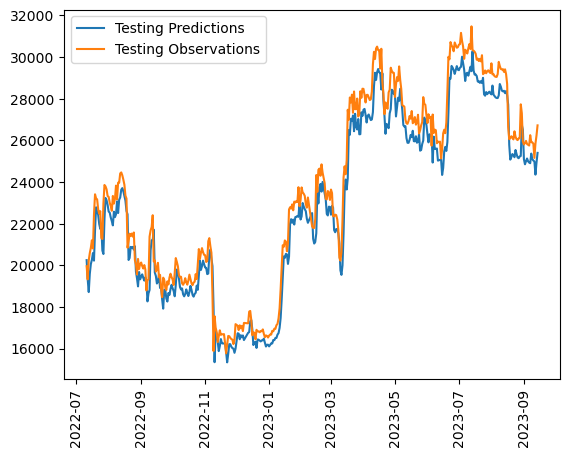

In [20]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [21]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9538719462081712


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [22]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [23]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1648,),
 (1648, 7),
 (1648,),
 (253,),
 (253, 7),
 (253,),
 (212,),
 (212, 7),
 (212,))

In [24]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
52/52 [==============================] - 3s 16ms/step - loss: 86.1741 - mean_absolute_error: 9.2410 - val_loss: 85.9490 - val_mean_absolute_error: 9.2697
Epoch 2/200
52/52 [==============================] - 0s 7ms/step - loss: 72.9013 - mean_absolute_error: 8.4917 - val_loss: 68.6221 - val_mean_absolute_error: 8.2825
Epoch 3/200
52/52 [==============================] - 0s 7ms/step - loss: 50.4120 - mean_absolute_error: 7.0260 - val_loss: 40.3015 - val_mean_absolute_error: 6.3466
Epoch 4/200
52/52 [==============================] - 0s 7ms/step - loss: 24.0650 - mean_absolute_error: 4.7829 - val_loss: 15.0777 - val_mean_absolute_error: 3.8800
Epoch 5/200
52/52 [==============================] - 0s 7ms/step - loss: 6.7568 - mean_absolute_error: 2.3655 - val_loss: 2.7674 - val_mean_absolute_error: 1.6563
Epoch 6/200
52/52 [==============================] - 0s 7ms/step - loss: 1.2429 - mean_absolute_error: 0.8509 - val_loss: 0.3019 - val_mean_absolute_error: 0.5273
Epoch 7/200
5

Epoch 51/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0483 - val_loss: 0.0082 - val_mean_absolute_error: 0.0769
Epoch 52/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0481 - val_loss: 0.0041 - val_mean_absolute_error: 0.0469
Epoch 53/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0485 - val_loss: 0.0033 - val_mean_absolute_error: 0.0395
Epoch 54/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0477 - val_loss: 0.0051 - val_mean_absolute_error: 0.0559
Epoch 55/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0474 - val_loss: 0.0050 - val_mean_absolute_error: 0.0548
Epoch 56/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0476 - val_loss: 0.0030 - val_mean_absolute_error: 0.0363
Epoch 57/200
52/

Epoch 101/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0460 - val_loss: 0.0039 - val_mean_absolute_error: 0.0463
Epoch 102/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0451 - val_loss: 0.0028 - val_mean_absolute_error: 0.0358
Epoch 103/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0442 - val_loss: 0.0042 - val_mean_absolute_error: 0.0491
Epoch 104/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0453 - val_loss: 0.0031 - val_mean_absolute_error: 0.0388
Epoch 105/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0441 - val_loss: 0.0031 - val_mean_absolute_error: 0.0387
Epoch 106/200
52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0455 - val_loss: 0.0028 - val_mean_absolute_error: 0.0355
Epoch 107/

Epoch 151/200
52/52 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0436 - val_loss: 0.0026 - val_mean_absolute_error: 0.0353
Epoch 152/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0427 - val_loss: 0.0024 - val_mean_absolute_error: 0.0331
Epoch 153/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0414 - val_loss: 0.0033 - val_mean_absolute_error: 0.0425
Epoch 154/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0434 - val_loss: 0.0038 - val_mean_absolute_error: 0.0472
Epoch 155/200
52/52 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0435 - val_loss: 0.0029 - val_mean_absolute_error: 0.0386
Epoch 156/200
52/52 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0422 - val_loss: 0.0023 - val_mean_absolute_error: 0.0313
Epoch 157/

52/52 [==============================] - 1s 3ms/step


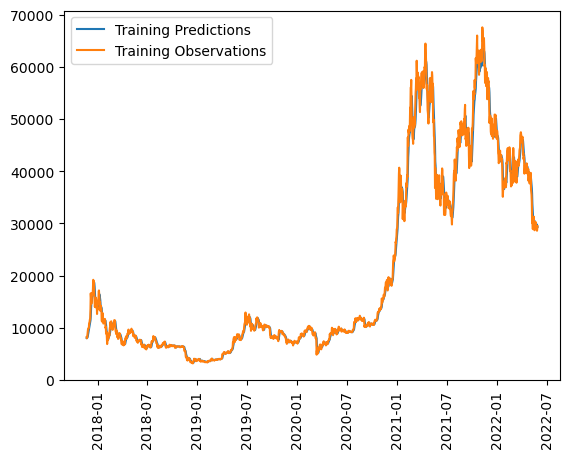

In [25]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [26]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0021479667630046606
Val MAE: 0.030979687348008156


8/8 [==============================] - 0s 6ms/step


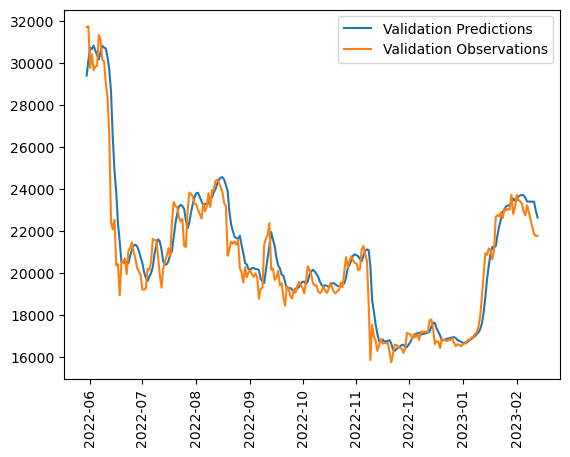

In [27]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [28]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0010605627903714776
Test MAE: 0.024223120883107185


In [29]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 4ms/step
R2 Score:  0.8656700308150436


7/7 [==============================] - 0s 4ms/step


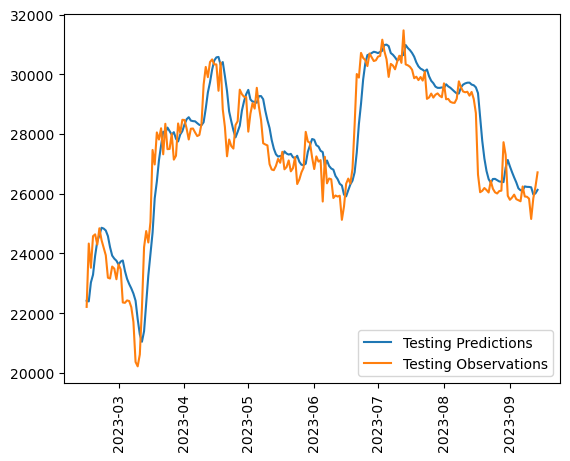

In [30]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
52/52 [==============================] - 3s 16ms/step - loss: 83.1883 - mean_absolute_error: 9.0782 - val_loss: 83.1574 - val_mean_absolute_error: 9.1179
Epoch 2/300
52/52 [==============================] - 0s 6ms/step - loss: 69.3682 - mean_absolute_error: 8.2784 - val_loss: 64.4591 - val_mean_absolute_error: 8.0273
Epoch 3/300
52/52 [==============================] - 0s 7ms/step - loss: 46.2395 - mean_absolute_error: 6.7198 - val_loss: 34.8840 - val_mean_absolute_error: 5.9044
Epoch 4/300
52/52 [==============================] - 0s 7ms/step - loss: 17.3187 - mean_absolute_error: 3.9530 - val_loss: 7.1670 - val_mean_absolute_error: 2.6727
Epoch 5/300
52/52 [==============================] - 0s 7ms/step - loss: 2.3604 - mean_absolute_error: 1.2151 - val_loss: 0.4240 - val_mean_absolute_error: 0.6327
Epoch 6/300
52/52 [==============================] - 0s 7ms/step - loss: 0.7959 - mean_absolute_error: 0.7675 - val_loss: 0.1674 - val_mean_absolute_error: 0.3792
Epoch 7/300
52

Epoch 51/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_absolute_error: 0.0524 - val_loss: 0.0037 - val_mean_absolute_error: 0.0420
Epoch 52/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0514 - val_loss: 0.0046 - val_mean_absolute_error: 0.0504
Epoch 53/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0519 - val_loss: 0.0058 - val_mean_absolute_error: 0.0597
Epoch 54/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0505 - val_loss: 0.0044 - val_mean_absolute_error: 0.0487
Epoch 55/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0504 - val_loss: 0.0036 - val_mean_absolute_error: 0.0416
Epoch 56/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_absolute_error: 0.0500 - val_loss: 0.0031 - val_mean_absolute_error: 0.0371
Epoch 57/300
52/

Epoch 101/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0491 - val_loss: 0.0041 - val_mean_absolute_error: 0.0473
Epoch 102/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0468 - val_loss: 0.0032 - val_mean_absolute_error: 0.0392
Epoch 103/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0468 - val_loss: 0.0040 - val_mean_absolute_error: 0.0461
Epoch 104/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0463 - val_loss: 0.0028 - val_mean_absolute_error: 0.0348
Epoch 105/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0477 - val_loss: 0.0037 - val_mean_absolute_error: 0.0439
Epoch 106/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0502 - val_loss: 0.0028 - val_mean_absolute_error: 0.0348
Epoch 107/

Epoch 151/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0466 - val_loss: 0.0030 - val_mean_absolute_error: 0.0379
Epoch 152/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0435 - val_loss: 0.0028 - val_mean_absolute_error: 0.0359
Epoch 153/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0447 - val_loss: 0.0032 - val_mean_absolute_error: 0.0397
Epoch 154/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0438 - val_loss: 0.0025 - val_mean_absolute_error: 0.0326
Epoch 155/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0025 - val_mean_absolute_error: 0.0327
Epoch 156/300
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0440 - val_loss: 0.0026 - val_mean_absolute_error: 0.0334
Epoch 157/

Epoch 201/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0410 - val_loss: 0.0023 - val_mean_absolute_error: 0.0324
Epoch 202/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0435 - val_loss: 0.0022 - val_mean_absolute_error: 0.0327
Epoch 203/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0433 - val_loss: 0.0026 - val_mean_absolute_error: 0.0355
Epoch 204/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0417 - val_loss: 0.0021 - val_mean_absolute_error: 0.0304
Epoch 205/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0424 - val_loss: 0.0028 - val_mean_absolute_error: 0.0376
Epoch 206/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0400 - val_loss: 0.0022 - val_mean_absolute_error: 0.0305
Epoch 207/

52/52 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0396 - val_loss: 0.0019 - val_mean_absolute_error: 0.0286
Epoch 251/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0393 - val_loss: 0.0020 - val_mean_absolute_error: 0.0304
Epoch 252/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0413 - val_loss: 0.0018 - val_mean_absolute_error: 0.0281
Epoch 253/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0389 - val_loss: 0.0018 - val_mean_absolute_error: 0.0282
Epoch 254/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0392 - val_loss: 0.0034 - val_mean_absolute_error: 0.0454
Epoch 255/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0440 - val_loss: 0.0025 - val_mean_absolute_error: 0.0359
Epoch 256/300
52/52 [===

Epoch 300/300
52/52 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0375 - val_loss: 0.0016 - val_mean_absolute_error: 0.0267


52/52 [==============================] - 1s 3ms/step


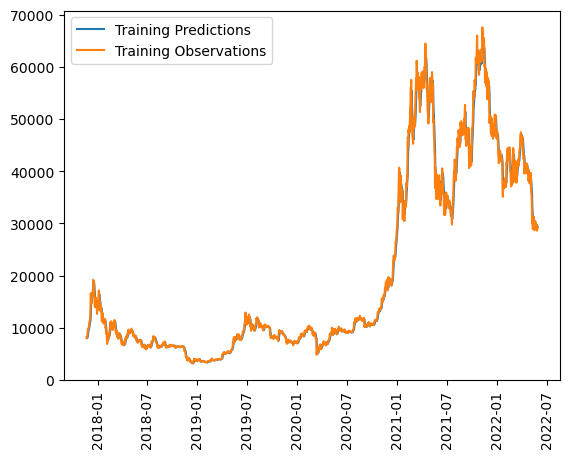

In [32]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [33]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0016469861147925258
Val MAE: 0.02672795206308365


8/8 [==============================] - 0s 4ms/step


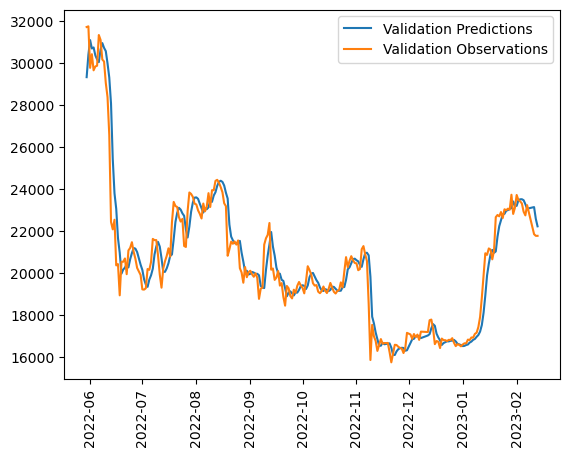

In [34]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [35]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.000846371054649353
Test MAE: 0.020293496549129486


7/7 [==============================] - 0s 5ms/step


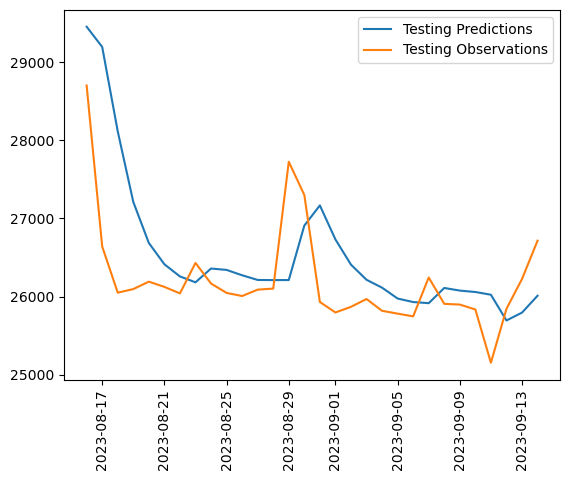

In [36]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [37]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.892799333326754


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [48]:


# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 14

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1].reshape((1, lookback, 1))
initial_date = dates_test2[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# Assuming 'predictions' contains your 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 23ms/step
[10.166311, 10.16849, 10.171141, 10.174116, 10.177103, 10.179117, 10.181321, 10.183907, 10.186392, 10.188858, 10.191321, 10.193796, 10.196303, 10.198817]
2023-09-15
2023-09-16
2023-09-17
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25
2023-09-26
2023-09-27
2023-09-28


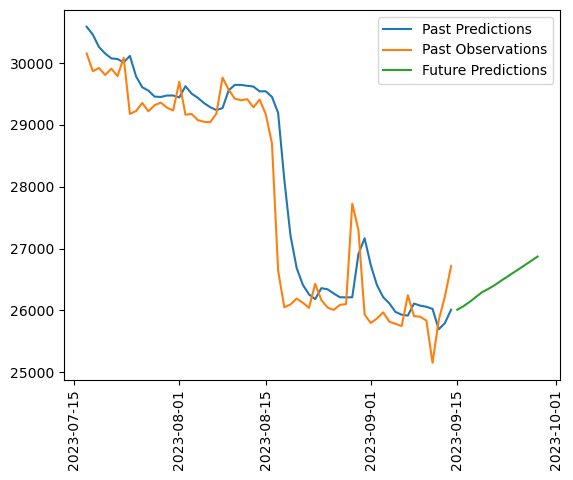

In [49]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [50]:
# Export model to HDF5 file
model3.save("H5_Files/btc_7_day.h5")

In [41]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2, "observed":np.exp(y_test2), "predicted":np.exp(test_predictions3)})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,predicted,future_prediction
Date,,,
2023-02-14,22211.0,22031.548828,NaN
2023-02-15,24332.0,22095.054688,NaN
2023-02-16,23521.0,23046.607422,NaN
2023-02-17,24580.0,23309.466797,NaN
2023-02-18,24640.0,23987.748047,NaN


In [42]:
past_future_df.tail()

,observed,predicted,future_prediction
Date,,,
2023-09-17,NaN,NaN,26137.875000
2023-09-18,NaN,NaN,26215.761719
2023-09-19,NaN,NaN,26294.183594
2023-09-20,NaN,NaN,26347.197266
2023-09-21,NaN,NaN,26405.328125


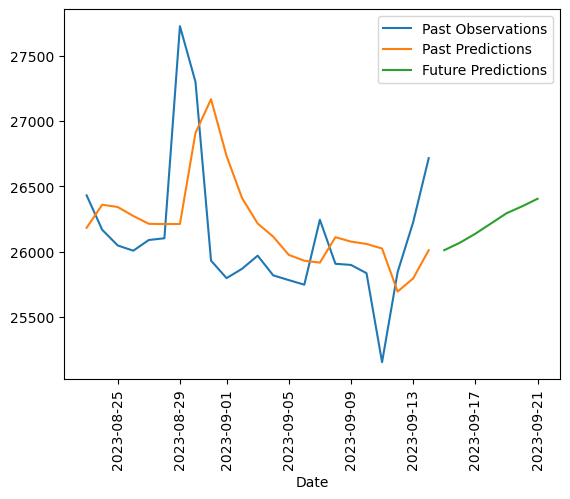

In [43]:
past_future_df[-30:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Past Observations', 'Past Predictions','Future Predictions'])
plt.show()

In [55]:
past_df = pd.read_csv('output/btc_predict.csv')

past_df = past_df[["predicted"]]

past_df = past_df.rename(columns={"predicted":"past_pred"})

df_combined = pd.merge(past_future_df,past_df, how='outer', left_index=True, right_index=True)

df_combined.head()

,observed,predicted,future_prediction,past_pred
2023-02-14,22211.0,22031.548828,NaN,NaN
2023-02-15,24332.0,22095.054688,NaN,NaN
2023-02-16,23521.0,23046.607422,NaN,NaN
2023-02-17,24580.0,23309.466797,NaN,NaN
2023-02-18,24640.0,23987.748047,NaN,NaN


In [59]:
#output prediction data to csv
df.to_csv('output/btc_predict.csv') 

In [57]:
#output original historical data to csv
data.to_csv('output/btc_lifetime.csv')

In [58]:
#output original historical data to csv
df_combined.to_csv('output/btc_predict_hist.csv')